In [2]:
import plistlib
import numpy as np
import skimage.draw
from pydicom import dcmread
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [5]:
dicom_path = r'In_Breast_2012\AllDICOMs\22580367_5eae9beae14d26fd_MG_L_CC_ANON.dcm'
XML_path = r'In_Breast_2012\AllXML\22580367.xml'
directory = r'In_Breast_2012\AllXML'

In [7]:
dicom_file = dcmread(dicom_path)
dicom_img = dicom_file.pixel_array
imshape = np.shape(dicom_img)

In [8]:
def cargar_puntos(point_string):
    x,y = tuple([float(i) for i in point_string.strip('()').split(',')])
    return y,x

In [19]:
def generar_mascara(xml_path,imshape=(4084,3328)):
    """
    Genera una mascara a partir de un archivo XML formato plist de apple
    
    @xml_path : Directorio del archivo xml
    @imshape : La forma que debe tener la mascara ej:(4084,3328)
     
    return: numpy array donde cada masa tiene un valor distinto en la mascara
    """
    mascara = np.zeros(imshape)
    with open (xml_path,'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML, dict_type=dict)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']

        i = 0
        for roi in rois:
            if roi["Name"] == "Mass":
                i +=1
                # Convierto los elementos de la lista points de <str de coordenadas> a <tuplas de coordenadas>
                points = roi['Point_px']
                points = [cargar_puntos(point) for point in points]
                
                # Genero una mascara con todas las coordenadas del archivo XML
                x, y = zip(*points)
                x, y = np.array(x), np.array(y)
                poly_x, poly_y = skimage.draw.polygon(x,y, shape=imshape)
                mascara[poly_x, poly_y] = i
    return mascara


In [24]:
def mascara_a_yolo(mass_mask, img):
    """
    Convierte las mascaras a el formato 'yolo'.
    @mass_mask: mascara en formato numpy array donde cada pixel corresponde a una lesion

    return: una lista de listas que contienen los bounding boxes de cada lesion en coordenadas YOLO:
        x = centro_en_x/ancho_imagen

        y = centro_en_y/alto_imagen

        alto = alto_recuadro/alto_imagen
        
        ancho = ancho_recuadro/ancho_imagen
    """

    bbox = []
    alto, ancho = mass_mask.shape

    # Identifico la cantidad de masas que hay en la mascara
    cant_mass = len(np.unique(mass_mask))-1

    for i in range(cant_mass):
        mask = mass_mask.copy()

        #Genero una mascara por cada masa que hay en la mascara
        mask[mass_mask!=i+1] = 0
        
        #Obtengo las coordenadas que forman el contorno de la masa
        cnts,_ = cv.findContours(mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        #Obtengo el rectangulo que abarca el contorno obtenido
        x,y,w,h = cv.boundingRect(cnts[0])
        
        #Transformo los valores obtenidos del bbox al formato YOLO
        x_centro = x+w//2
        y_centro = y+h//2
        bbox.append([x_centro/ancho, y_centro/alto, w/ancho, h/alto, 'mass'])

        #Dibujo la/s bbox sobre la imagen 
        cv.rectangle(img,(x,y),(x+w,y+h),255,8)
    print(bbox)

    
    return bbox

In [25]:
mask = generar_mascara(XML_path, imshape)
bbox= mascara_a_yolo(mask,dicom_img)

(136, 166)
(518, 478)
[[0.16640625, 0.6586538461538461, 0.053125, 0.049879807692307696, 'mass'], [0.209765625, 0.4215745192307692, 0.20234375, 0.14362980769230768, 'mass']]


Text(0.5, 1.0, 'ROI')

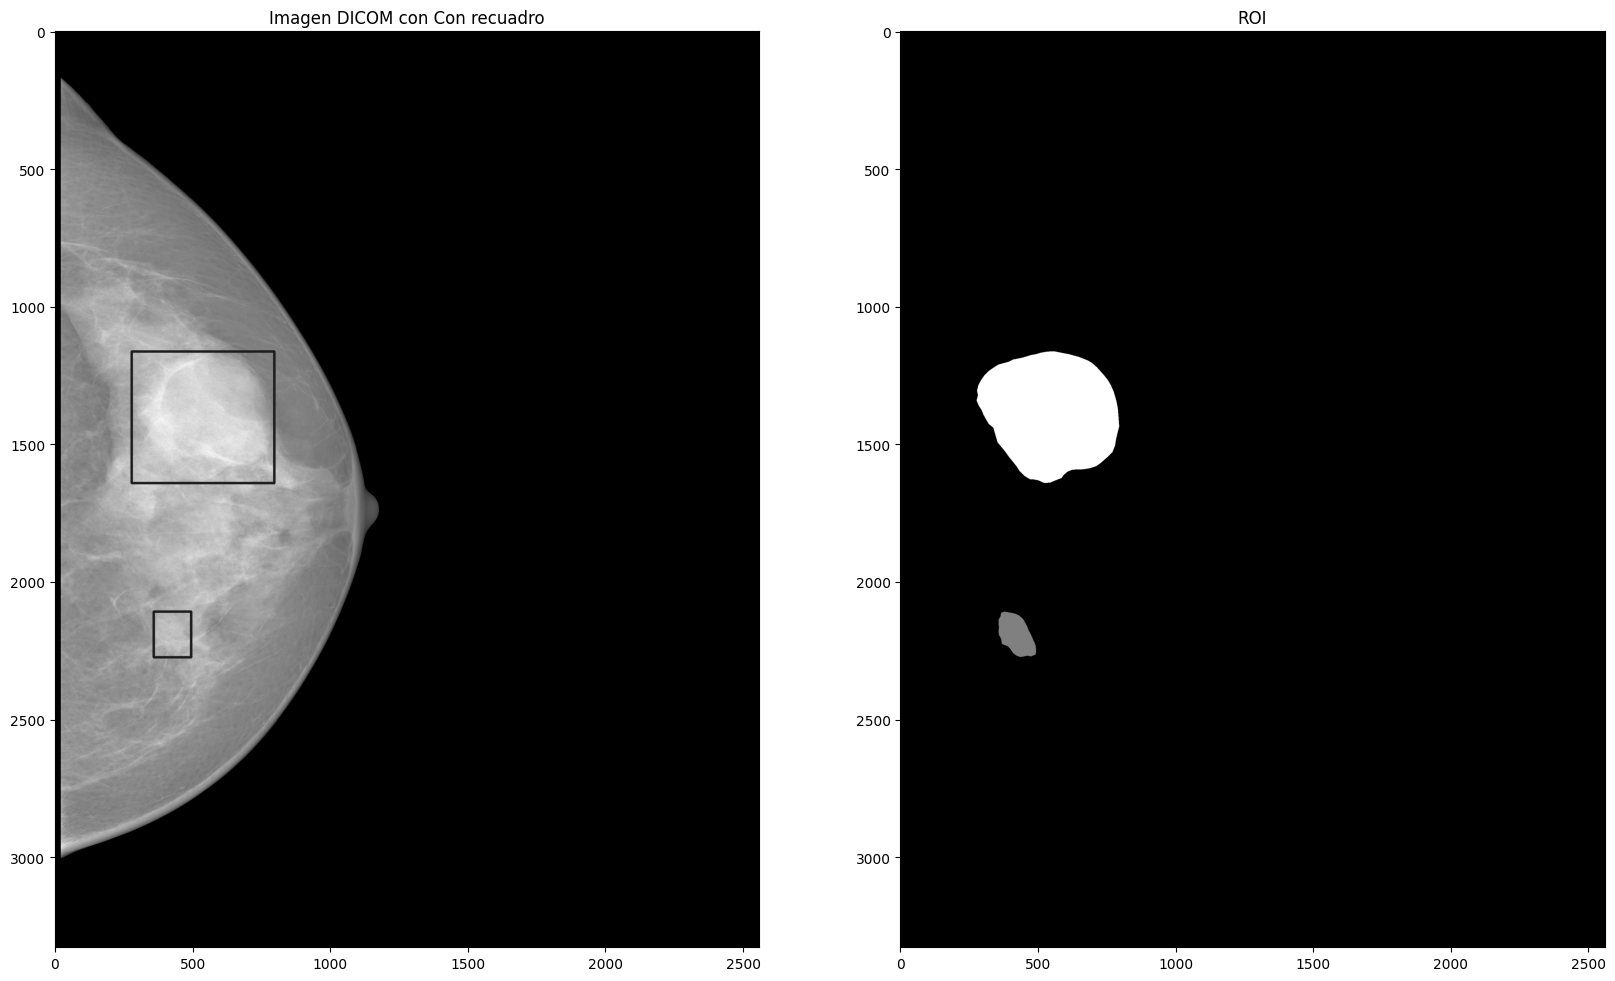

In [12]:
plt.figure(figsize=(20,35))
plt.subplot(1,2,1)
plt.imshow(dicom_img, cmap=plt.cm.gray)
plt.title('Imagen DICOM con Con recuadro')

plt.subplot(1,2,2)
plt.imshow(mask, cmap=plt.cm.gray)
plt.title("ROI")

In [6]:
for root, dir, files in os.walk(directory):
    for file in files:
        file = os.path.join(root,file)

        with open (file,'rb') as mascara:
            plist_dict = plistlib.load(mascara, fmt=plistlib.FMT_XML, dict_type=dict)['Images'][0]
            numRois = plist_dict['NumberOfROIs']
            rois = plist_dict['ROIs']
            counts = {}
            
            for roi in rois:
                lesion = roi['Name']
                if lesion in counts:
                    counts[lesion] +=1
                else:
                    counts[lesion] = 1
                    
            print(f'Archivo:{file}, ROIs:{counts}')


Archivo:In_Breast_2012\AllXML\20586908.xml, ROIs:{'Calcification': 40, 'Mass': 2}
Archivo:In_Breast_2012\AllXML\20586934.xml, ROIs:{'Calcification': 60, 'Spiculated Region': 1, 'Mass': 1}
Archivo:In_Breast_2012\AllXML\20586960.xml, ROIs:{'Calcification': 43, 'Mass': 2}
Archivo:In_Breast_2012\AllXML\20586986.xml, ROIs:{'Calcification': 14, 'Spiculated Region': 1, 'Mass': 1}
Archivo:In_Breast_2012\AllXML\20587054.xml, ROIs:{'Cluster': 3}
Archivo:In_Breast_2012\AllXML\20587080.xml, ROIs:{'Cluster': 3}
Archivo:In_Breast_2012\AllXML\20587148.xml, ROIs:{'Calcification': 3}
Archivo:In_Breast_2012\AllXML\20587174.xml, ROIs:{'Unnamed': 2, 'Calcification': 13}
Archivo:In_Breast_2012\AllXML\20587200.xml, ROIs:{'Calcification': 5}
Archivo:In_Breast_2012\AllXML\20587226.xml, ROIs:{'Calcification': 24}
Archivo:In_Breast_2012\AllXML\20587294.xml, ROIs:{'Calcification': 2}
Archivo:In_Breast_2012\AllXML\20587320.xml, ROIs:{'Calcification': 7}
Archivo:In_Breast_2012\AllXML\20587346.xml, ROIs:{'Calcifica

In [1]:
import torch

print(torch.cuda.is_available())

False
